In [117]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1.Import dataset

In [118]:
ds_path = '/content/drive/MyDrive/filoger project/LSTM model/META.csv'

In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [120]:
meta_ds = pd.read_csv(ds_path)

In [121]:
len(meta_ds)


763

In [122]:
meta_ds.describe()

,Open,High,Low,Close,Adj Close,Volume
count,763.000000,763.000000,763.000000,763.000000,763.000000,7.630000e+02
mean,253.520537,257.024627,250.014797,253.519175,253.519175,2.178305e+07
std,61.336326,61.734640,61.019671,61.408915,61.408915,1.335438e+07
min,139.750000,148.179993,137.100006,146.009995,146.009995,6.046300e+06
25%,199.254998,201.250000,195.535004,198.665001,198.665001,1.384520e+07
50%,246.500000,249.949997,240.080002,245.419998,245.419998,1.837950e+07
75%,307.329987,311.750000,303.835006,307.460006,307.460006,2.626155e+07
max,381.679993,384.329987,378.809998,382.179993,382.179993,1.881199e+08


In [123]:
meta_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 763 entries, 0 to 762
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       763 non-null    object 
 1   Open       763 non-null    float64
 2   High       763 non-null    float64
 3   Low        763 non-null    float64
 4   Close      763 non-null    float64
 5   Adj Close  763 non-null    float64
 6   Volume     763 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 41.9+ KB


In [124]:
meta_ds_close = meta_ds.iloc[:, 4].values

In [125]:
meta_ds_close.size

763

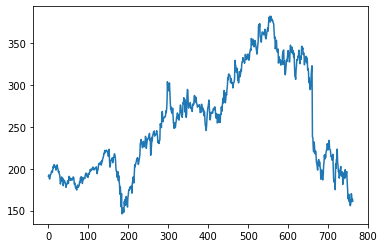

In [126]:
plt.plot(meta_ds_close)

# 2.preprocess the data:

In [127]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
meta_ds_close_scaled = scaler.fit_transform(meta_ds_close.reshape(-1, 1))

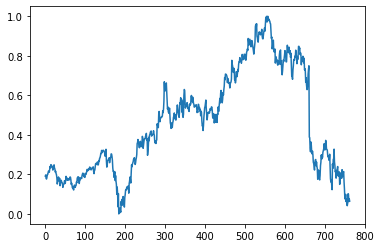

In [128]:
plt.plot(meta_ds_close_scaled)

In [129]:
X_meta_close= []
y_meta_close= []

In [130]:
for i in range(40, len(meta_ds_close_scaled)):
  X_meta_close.append(meta_ds_close_scaled[i-40:i, 0])
  y_meta_close.append(meta_ds_close_scaled[i, 0])

In [131]:
X_meta_close = np.array(X_meta_close)
y_meta_close = np.array(y_meta_close)

### Reshape

In [132]:
X_meta_close =np.reshape(X_meta_close, (X_meta_close.shape[0], X_meta_close.shape[1], 1))


In [133]:
X_meta_close.shape

(723, 40, 1)

In [134]:
y_meta_close = np.reshape(y_meta_close, (-1,1))


In [135]:
y_meta_close.shape

(723, 1)

### train_test_split

In [136]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_meta_close, y_meta_close,test_size = 0.2, random_state = 42 )

In [137]:
X_train.shape

(578, 40, 1)

In [138]:
y_train.shape

(578, 1)

# 3.Design Deep Model
### &
# 4.Compile
### &
# 5.Fit

In [145]:
from keras import Model
from keras.layers import Input, Dense
from keras.layers.recurrent import LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from keras import backend as K

def define_model():
    input1 = Input(shape=(40,1)) 
    x =LSTM(units=64, return_sequences=True)(input1)
    x = Dropout(0.2) (x)
    x = LSTM(units=64)(x)
    x = Dropout(0.2) (x)
    x = Dense(32, activation='sigmoid')(x)
    dnn_output = Dense(1)(x)
    model = Model(inputs=[input1],outputs=[dnn_output])
    
    # compile the model
    model.compile(loss='mean_squared_error', optimizer='Adam')
    model.summary()
    return model

# Call the model
model = define_model()

# Fit the model
history = model.fit(x=X_train,y=y_train,epochs=300,batch_size=32, validation_split=0.1)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 40, 1)]           0         
                                                                 
 lstm_25 (LSTM)              (None, 40, 64)            16896     
                                                                 
 dropout_25 (Dropout)        (None, 40, 64)            0         
                                                                 
 lstm_26 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_26 (Dropout)        (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 32)                2080      
                                                                 
 dense_16 (Dense)            (None, 1)                 33  

# 6.Evaluation

In [146]:
results = model.evaluate(X_test, y_test)
results

5/5 [==============================] - 0s 14ms/step - loss: 6.7511e-04


0.0006751085165888071

In [147]:
predictions = model.predict(X_test)
# predictions
predictions.shape

(145, 1)

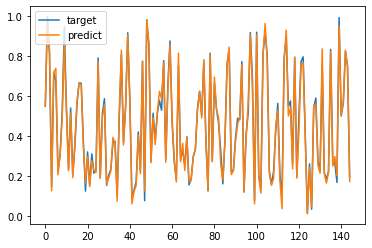

In [148]:
plt.plot(y_test,'')
plt.plot(predictions)
plt.legend(['target', 'predict'], loc='upper left')
plt.show()

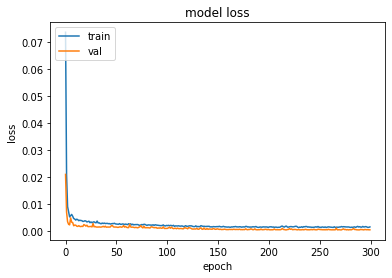

In [149]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# accuracy 

In [150]:
from sklearn.metrics import r2_score
r2_score(y_test , predictions)

0.989890387125308

# 7.Predict the close price for tomorrow

In [156]:
tomorrow_prediction = model.predict(X_meta_close[-1:, :])
tomorrow=scaler.inverse_transform(tomorrow_prediction)
tomorrow

array([[159.79247]], dtype=float32)

## Real value for tomorrow ---> **160.029999**
## Predicted value for tomorrow ---> **159.79247**🥇

